In [1]:
%matplotlib inline
import os
import sys

module_path = os.path.abspath(os.path.join("../../."))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import datetime

import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
from qutip import Qobj, basis, mesolve, ket2dm
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

%load_ext autoreload
%autoreload 
import QTransferLib as qtr
import Pulses as pulses
import Plots as plots

2023-06-12 20:06:27.147988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 20:06:27.710236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pabolojo/miniconda3/envs/quantum/lib/python3.9/site-packages/tf_agents/__init__.py:56: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf_version) <
/home/pabolojo/miniconda3/envs/quantum/lib/python3.9/site-packages/tf_agents/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
/home/pabolojo/miniconda3/envs/quantum/lib/python3.9/site-packages/tensorflow

In [2]:
# Optimization algorithm to be used
opt_alg = 'CRAB' # 'GRAPE' or 'CRAB'

# Number of time slots
n_ts = 100

# Time allowed for the evolution
T_max = 50

# Number of Qubit Spaces
N = 3

# Energy Relative Levels
Deltas = np.zeros(N, dtype=complex)

# Maximumum pulse amplitude
max_pulse_amplitude = 1.

# Dephase rate
gamma = 0

In [3]:
# Fidelity error target
fid_err_targ = 1e-2
# Maximum iterations for the optisation algorithm
max_iter = 20000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300

In [4]:
#Set to None to suppress output files
f_ext = "{}_{}_n_ts{}.txt".format(N, opt_alg, n_ts)

In [5]:
# Drift Hamiltonian
H = np.diag(Deltas)
for c_op in np.array(qtr.dephase_factory(N, gamma)):
    H += c_op

H_d = Qobj(H)
H_c = []

# The (N - 1) control Hamiltonians
for i in range(N - 1):
    H_c.append(qtr.hamiltonian_coupling_factory(N, i))

n_ctrls = len(H_c)

In [6]:
# Start point for the gate evolution
psi0 = basis(N, 0)

# Target for the system evolution - Quantum Trnasfer
psiTarg = basis(N, N - 1)

In [7]:
# Starting pulses
init_pulses = np.random.uniform(0., 1., size=(n_ts, N-1))#pulses.STA_pulses(N, T_max, n_ts, max_pulse_amplitude, 20*max_pulse_amplitude) # pulses.CTAP_pulses(N, T_max, n_ts, T_max/6, T_max/6, max_pulse_amplitude)

In [8]:
optim = cpo.create_pulse_optimizer(H_d, H_c, psi0, psiTarg, n_ts, T_max, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                alg=opt_alg,
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'PSU'}, 
                log_level=log_level, gen_stats=True,
                amp_lbound=0.000000000001, amp_ubound=max_pulse_amplitude)

In [9]:
dyn = optim.dynamics

if opt_alg == 'CRAB':
    for j in range(dyn.num_ctrls):
        pgen = optim.pulse_generator[j]
        pgen.init_pulse()

dyn.initialize_controls(init_pulses)

INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 2, which means a total of 4 optimisation variables for this pulse. Based on the dimension (3) of the system
INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 2, which means a total of 4 optimisation variables for this pulse. Based on the dimension (3) of the system
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False


In [10]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

INFO:qutip.control.optimizer:Optimising pulse(s) using CRAB with 'fmin' (Nelder-Mead) method


Initial amplitudes output to file: ctrl_amps_initial_3_CRAB_n_ts100.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_3_CRAB_n_ts100.txt


In [11]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.411137
Wall time computing Hamiltonians: 0:00:00.019846 (4.83%)
Wall time computing propagators: 0:00:00.360399 (87.66%)
Wall time computing forward propagation: 0:00:00.002831 (0.69%)
Wall time computing onward propagation: 0:00:00.002596 (0.63%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 24
Number of fidelity function calls: 40
Number of times fidelity is computed: 41
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 41

**** Control amplitudes ****
Number of control amplitude updates: 40
Mean number of updates per iteration: 1.6666666666666667
Number of timeslot values changed: 3999
Mean number of timeslot changes per update: 99.975
Number of amplitude values changed: 7298
Mean numbe

In [12]:
times, populations_initial = qtr.compute_populations(N, psi0, T_max, result.initial_amps, qtr.constant_delta_factory(Deltas, n_ts), qtr.dephase_factory(N, gamma))
times, populations_final = qtr.compute_populations(N, psi0, T_max, result.final_amps, qtr.constant_delta_factory(Deltas, n_ts), qtr.dephase_factory(N, gamma))

0.9546634878042237

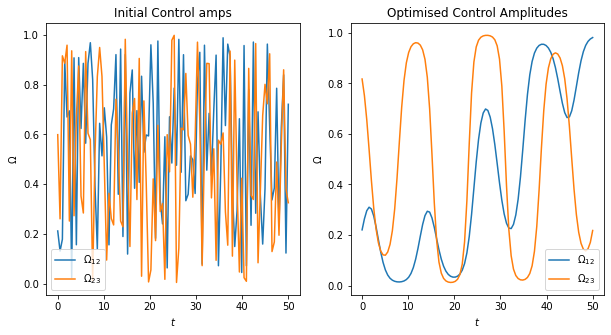

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plots.plot_pulses(times, result.initial_amps, axs[0])
plots.plot_pulses(times, result.final_amps, axs[1])

axs[0].set_title("Initial Control amps")
axs[1].set_title("Optimised Control Amplitudes")

np.max(np.abs(result.initial_amps - result.final_amps)**2)

0.8304600600364416

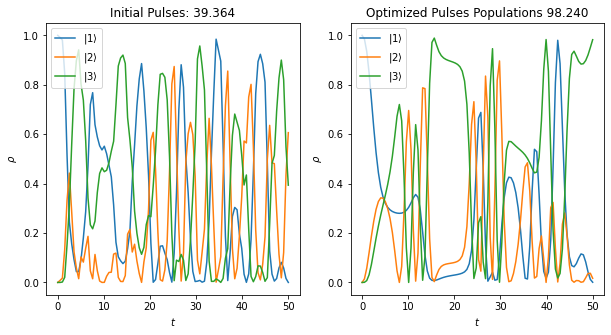

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plots.plot_populations(times, populations_initial, axs[0])
plots.plot_populations(times, populations_final, axs[1])

axs[0].set_title("Initial Pulses: %.3f" % (populations_initial[-1, -1]*100))
axs[1].set_title("Optimized Pulses Populations %.3f" % (populations_final[-1, -1]*100))

np.max(np.abs(populations_initial - populations_final)**2)

In [15]:
np.save('CRAB_50.npy', result.final_amps)